Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым

Ссылка на архив: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

### Импорты

In [ ]:
# Работа со временем
import time

# Работа с архивами
import zipfile

# Работа с файлами
from pathlib import Path

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Работа с массивами данных
import numpy as np

# Для построения матрицы ошибок
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Для рассчета весов классов
from sklearn.utils.class_weight import compute_class_weight

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Основные слои
from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    MaxPooling1D,
    SpatialDropout1D,
)

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Оптимизаторы для обучения нейронной сети
from tensorflow.keras.optimizers import Adam

# Функция для дополнения последовательностей до одинаковой длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

%matplotlib inline


### Загрузка и распаковка архива

In [ ]:
# ваше решение
if not Path("20writers.zip").exists():
    # Скачивание датасета из облака google
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip",
        quiet=False,
    )
# Распаковка архива с датасетом
if not Path("20writers").exists():
    with zipfile.ZipFile("20writers.zip", "r") as zip_ref:
        zip_ref.extractall("20writers")

### Подготовка данных

In [ ]:
path = Path("20writers") # Путь к папке с текстами
text = [] # Список для хранения текстов
class_names = [] # Список для хранения названий классов

# Считывание текстов из файлов и сохранение их в списки
for f in path.iterdir():
    class_names.append(f.name)
    text.append(f.read_text().replace("\n", " "))


In [ ]:
# Загрузка сочинения для классификации
essay = [Path("text.txt").read_text().replace("\n", " ")]

In [ ]:
text_lens = [len(t) for t in text]  # Список длин текстов
# Индексы для разделения текстов на обучающую и тестовую выборки
split_indices = [int(lenth * 0.8) for lenth in text_lens]
# Разделение текстов на обучающую и тестовую выборки
train_text = []
test_text = []
for i, t in enumerate(text):
    train_text.append(t[: split_indices[i]])
    test_text.append(t[split_indices[i] :])

#### Токенизация данных

In [ ]:
VOCAB_SIZE = 25_000  # Максимальное количество слов в словаре
WIN_SIZE = 4000  # Размер окна для скользящего окна
WIN_HOPE = 500  # Шаг окна для скользящего окна


# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)


In [ ]:
# Контекстный менеджер для замера времени выполнения кода
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))


In [ ]:
with timex():
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE,
        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
        lower=True,
        split=" ",
        oov_token="неизвестное_слово",
        char_level=False,
    )
    tokenizer.fit_on_texts(text)  # Обучение токенизатора на текстах
    # Преобразование текстов в последовательности индексов
    seq_train = tokenizer.texts_to_sequences(train_text)
    seq_test = tokenizer.texts_to_sequences(test_text)
    # Преобразование сочинения в последовательность индексов
    seq_essay = tokenizer.texts_to_sequences(essay)
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)
    # Формирование выборки для сочинения
    x_essay, _ = vectorize_sequence(seq_essay, WIN_SIZE, WIN_HOPE)


Время обработки: 18.71 с


In [ ]:
# Приведение последовательности сочинения к правильной длине
padded_essay = pad_sequences(seq_essay, maxlen=WIN_SIZE, padding="post")

### Расчет весов классов

In [10]:
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1),
)
class_weight_dict = dict(enumerate(class_weights))


### Функция для проверки модели, отрисовки матрицы ошибок

In [ ]:
def eval_model( # Функция для оценки модели
    model, history, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("График процесса обучения модели")
    ax1.plot(
        history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
    )
    ax1.plot(
        history.history["val_accuracy"],
        label="Доля верных ответов на проверочном наборе",
    )
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("Доля верных ответов")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )


### Создание и обучение модели

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step - accuracy: 0.0651 - loss: 3.2256 - val_accuracy: 0.0381 - val_loss: 2.9791
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 176ms/step - accuracy: 0.1907 - loss: 2.5639 - val_accuracy: 0.0834 - val_loss: 2.8530
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - accuracy: 0.4286 - loss: 1.6406 - val_accuracy: 0.3145 - val_loss: 2.2010
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.6787 - loss: 0.8722 - val_accuracy: 0.4847 - val_loss: 2.3627
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.8268 - loss: 0.4974 - val_accuracy: 0.3226 - val_loss: 3.3624
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.8708 - loss: 0.3478 - val_accuracy: 0.6239 - val_loss: 1.5130
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 161ms/step - accuracy: 0.9307 - loss: 0.2159 - val_accuracy: 0.5246 - val_loss: 2.4011
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.9406 - loss: 0

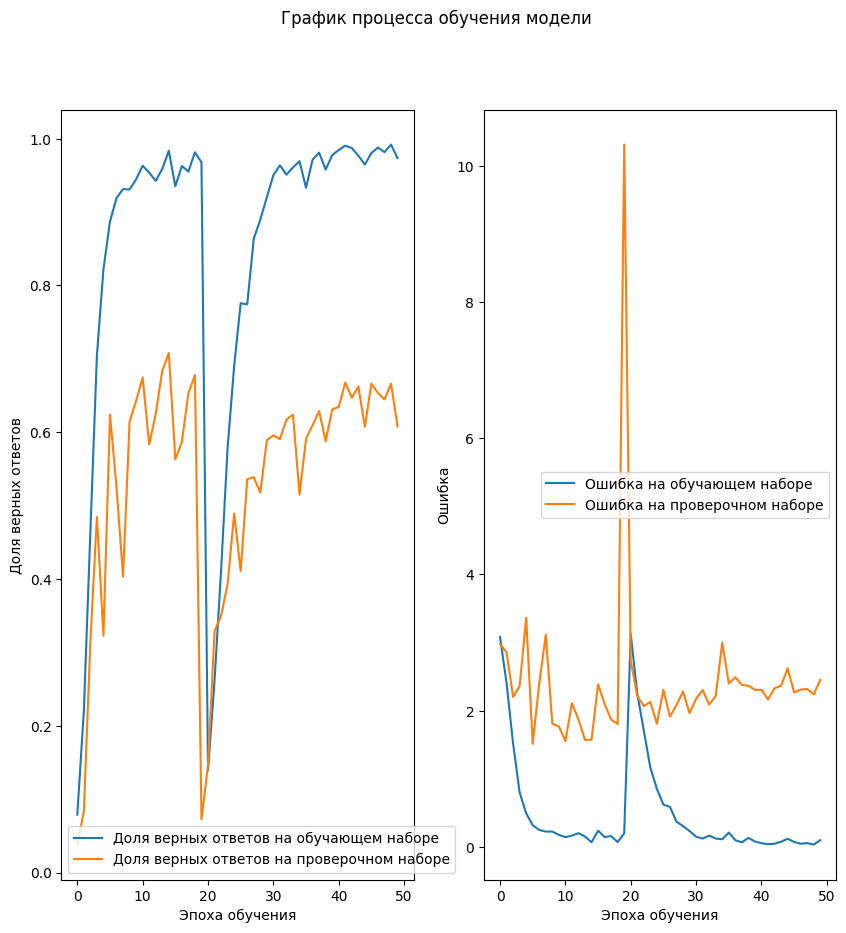

105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step


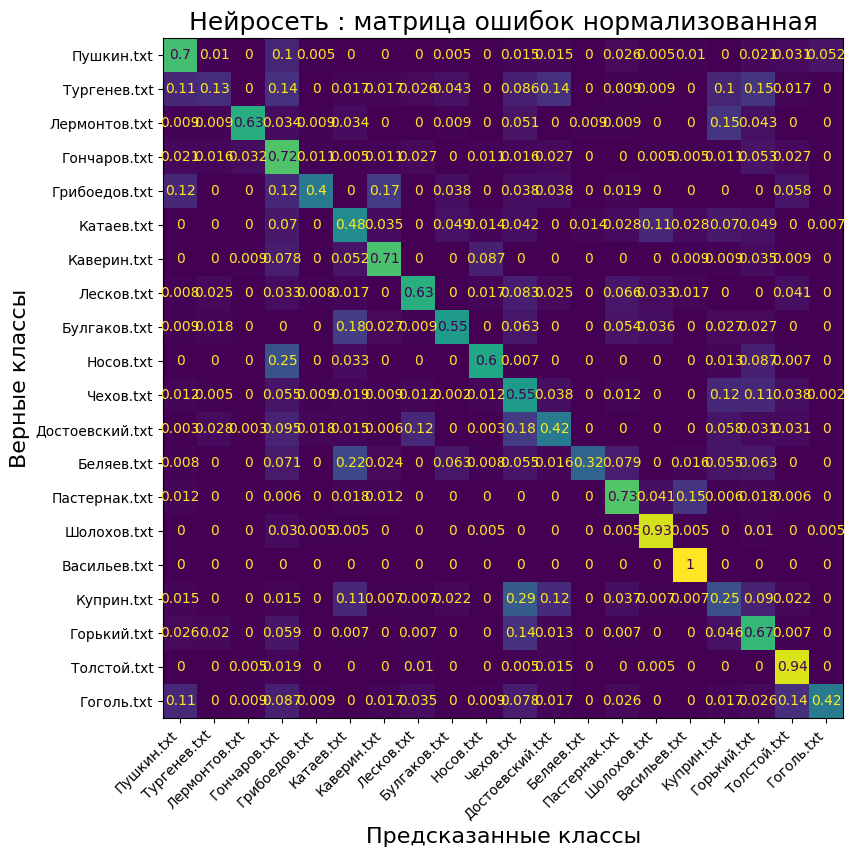

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Пушкин.txt            70% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Тургенев.txt          16% сеть отнесла к классу Горький.txt          - НЕВЕРНО :-(
Класс: Лермонтов.txt         63% сеть отнесла к классу Лермонтов.txt        - ВЕРНО :-)
Класс: Гончаров.txt          72% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Грибоедов.txt         40% сеть отнесла к классу Грибоедов.txt        - ВЕРНО :-)
Класс: Катаев.txt            48% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Каверин.txt           71% сеть отнесла к классу Каверин.txt          - ВЕРНО :-)
Класс: Лесков.txt            63% сеть отнесла к классу Лесков.txt           - ВЕРНО :-)
Класс: Булгаков.txt          55% сеть отнесла к классу Булгаков.txt         - ВЕРНО :-)
Класс: Носов.txt             60% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс

In [ ]:
model = Sequential(  # Конструирование модели нейронной сети
    [
        Embedding(VOCAB_SIZE, 128),
        SpatialDropout1D(0.2),
        Conv1D(32, 5, activation="relu", padding="same"),
        MaxPooling1D(2),
        BatchNormalization(),
        Conv1D(32, 5, activation="relu"),
        MaxPooling1D(2),
        BatchNormalization(),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(20, activation="softmax"),
    ]
)

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Обучение модели c использованием class_weight для балансировки классов
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_test, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

# Оценка модели на тестовой выборке
eval_model(model, history, x_test, y_test, class_names)

### Предсказание класса для сочинения

In [ ]:
prediction = model.predict(padded_essay) # Предсказание класса для сочинения
print(f"Предсказанный класс: {class_names[np.argmax(prediction)]}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Предсказанный класс: Каверин.txt
